In [ ]:
!wget https://www.python.org/ftp/python/3.7.0/Python-3.7.0.tgz
!tar xvfz Python-3.7.0.tgz
!Python-3.7.0/configure
!make
!sudo make install

In [ ]:
!pip uninstall keras
!pip uninstall -y tensorflow
!pip install tensorflow==2.8.0
!pip install keras==2.8.0
!pip install tensorflow-gpu==2.8.0
#!pip install h5py==2.10.0

In [55]:
!pip install h5py

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [4]:
from google.colab import files
dataset = files.upload()

Saving dataset_for_lstm.txt to dataset_for_lstm.txt


In [5]:
data = pd.read_csv("dataset_for_lstm.txt", names=['src', 'tag'], sep="\t")
data = data.reset_index()
data

,index,src,tag
0,1,나,O
1,1,는,O
2,1,학술,B_LOC
3,1,정보,I_LOC
4,1,관,I_LOC
...,...,...,...
30569,4427,가고,O
30570,4427,싶어요,O
30571,4428,우리,O
30572,4428,대,B_LOC


In [6]:
data[:5]

,index,src,tag
0,1,나,O
1,1,는,O
2,1,학술,B_LOC
3,1,정보,I_LOC
4,1,관,I_LOC


In [7]:
data.keys()

Index(['index', 'src', 'tag'], dtype='object')

In [8]:
len(data)

30574

<Axes: >

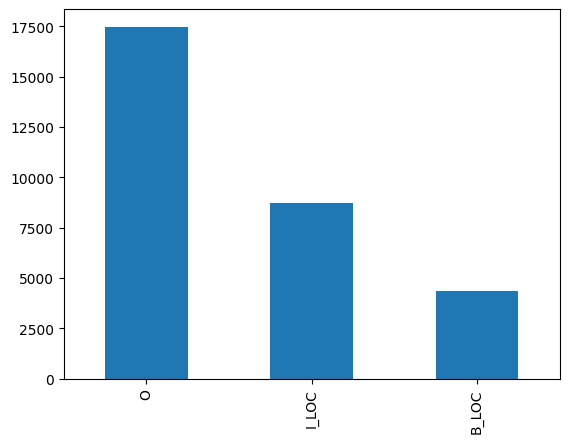

In [9]:
data['tag'].value_counts().plot(kind = 'bar')

In [10]:
data.groupby('tag').size().reset_index(name='count')

,tag,count
0,B_LOC,4369
1,I_LOC,8730
2,O,17475


In [11]:
func = lambda temp: [(w, t) for w, t in zip(temp["src"].values.tolist(), temp["tag"].values.tolist())]
tagged_sentences=[t for t in data.groupby("index").apply(func)]

In [12]:
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    ner_tags.append(list(tag_info))

In [13]:
tagged_sentences[2]

[('본관', 'B_LOC'), ('에', 'O'), ('갈거야', 'O')]

In [14]:
sentences[1]
#ner_tags[0]

['본관', '에', '가고', '싶어']

In [15]:
ner_tags[1]

['B_LOC', 'O', 'O', 'O']

In [16]:
sentences[1],
ner_tags[1]

['B_LOC', 'O', 'O', 'O']

In [17]:
src_tokenizer = Tokenizer(filters=None, lower=False)###
tar_tokenizer = Tokenizer(filters=None, lower=False)####
src_tokenizer = Tokenizer(oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False)
tar_tokenizer.fit_on_texts(ner_tags)

In [18]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 112
개체명 태깅 정보 집합의 크기 : 4


In [19]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [20]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [21]:
print(X_data[0])
print(y_data[0])

[4, 5, 35, 36, 7, 3, 28, 47]
[1, 1, 3, 2, 2, 1, 1, 3]


In [22]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [23]:
print(index_to_ner)

{1: 'O', 2: 'I_LOC', 3: 'B_LOC', 0: 'PAD'}


In [24]:
decoded = []
for index in X_data[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['나', '는', '학술', '정보', '관', '에', '갈거야', '본관']
디코딩 문장 : ['나', '는', '학술', '정보', '관', '에', '갈거야', '본관']


In [25]:
max_len = 20
# 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.2, random_state=777)

In [27]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [28]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3542, 20)
훈련 샘플 레이블의 크기 : (3542, 20, 4)
테스트 샘플 문장의 크기 : (886, 20)
테스트 샘플 레이블의 크기 : (886, 20, 4)


In [ ]:
!pip install seqeval

In [38]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score, classification_report

In [84]:
class F1score(Callback):
    def __init__(self, value = 0.0, use_char=True):
        super(F1score, self).__init__()
        self.value = value
        self.use_char = use_char

    def sequences_to_tags(self, sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
      result = []
      for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
          tag = []
          for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
              pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
              tag.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
          result.append(tag)
      return result

    # 에포크가 끝날 때마다 실행되는 함수
    def on_epoch_end(self, epoch, logs=None):
      model.save('/content/ai_model.h5', overwrite=True)


      if self.validation_data is None:
        return

      # char Embedding을 사용하는 경우
      if self.use_char:
        X_test = self.validation_data[0]
        X_char_test = self.validation_data[1]
        y_test = self.validation_data[2]
        y_predicted = self.model.predict([X_test, X_char_test])

      else:
        X_test = self.validation_data[0]
        y_test = self.validation_data[1]
        y_predicted = self.model.predict([X_test])

      pred_tags = self.sequences_to_tags(y_predicted)
      test_tags = self.sequences_to_tags(y_test)

      score = f1_score(pred_tags, test_tags)
      print(' - f1: {:04.2f}'.format(score * 100))
      print(classification_report(test_tags, pred_tags))

      # F1-score가 지금까지 중 가장 높은 경우
      try:
        model.save('/content/ai_model.h5', overwrite=True)
        self.value = score
        #print('f1_score improved from %f to %f, saving model to best_model.h5'%(self.value, score))
        #self.model.save('ai_model.h5', overwrite=True)
        #self.value = score
      except Exception as e:
        print("Error during model saving: ", str(e))


In [60]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam
from keras.models import load_model


In [61]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [85]:
history = model.fit(X_train, y_train, batch_size=32, epochs=1,  validation_split=0.1, callbacks=[F1score()])

100/100 [==============================] - 17s 175ms/step - loss: 4.9838e-05 - accuracy: 1.0000 - val_loss: 5.2428e-05 - val_accuracy: 1.0000


In [80]:
print(os.getcwd())

/content


In [86]:
bilstm_model = load_model('ai_model.h5')

In [92]:
i=15 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = bilstm_model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
나                : O       O
대                : B_LOC   B_LOC
운동장              : I_LOC   I_LOC
가도               : O       O
될까               : O       O
요                : O       O
